# Demo on PBMC dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import scvi

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import q2r_uncertainty
import diff2atlas


Global seed set to 0


In [3]:
import celltypist

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import anndata2ri
anndata2ri.activate()

dirname: Trying to get version of get_version from dirname /home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages
dirname: Failed; Does not match re.compile('get[_-]version-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
git: Trying to get version from git in directory /home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages
git: Failed; directory is not managed by git
metadata: Trying to get version for get_version in dir /home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages
metadata: Succeeded
dirname: Trying to get version of anndata2ri from dirname /home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages
dirname: Failed; Does not match re.compile('anndata2ri-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
git: Trying to get version from git in directory /home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages
git: Failed; directory is not managed by git
metadata: Trying to get version for anndata2ri in dir /home/jovyan/my-cond

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(patchwork)

### Load dataset

Built in [here](https://github.com/emdann/query2reference_uncertainty/blob/master/notebooks/PBMC_metanalysis/20220531_PBMC_metadata.ipynb)

In [7]:
data_dir = '/nfs/team205/ed6/data/PBMC_CZI_integration_filtered/'
adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.h5ad')

In [8]:
sample_obs = pd.read_csv(data_dir + 'PBMC_sample_metadata.normal.csv')

In [9]:
%%R -i sample_obs
dim(sample_obs)

[1] 1268   11


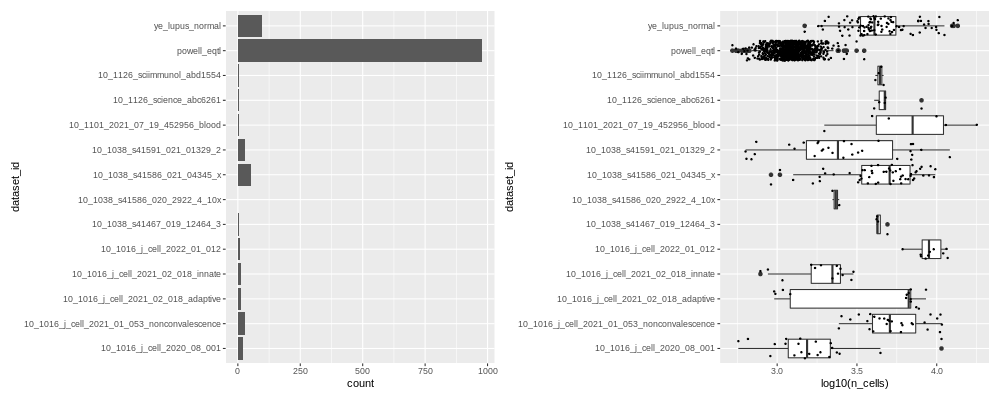

In [10]:
%%R -w 1000 -h 400
sample_obs %>%
    ggplot(aes(dataset_id)) +
    geom_bar( ) +
    coord_flip() +
sample_obs %>%
ggplot(aes(dataset_id, log10(n_cells))) +
geom_boxplot() +
geom_jitter(size=0.5) +
scale_fill_viridis_c() +
coord_flip()

### Design

- select one dataset to be query
- split in perturb and control (don't use two different datasets for now, otherwise you need to match)
- remove query-specific cluster from control and reference  

In [64]:
batch_obs = 'dataset_id'
query_dataset = '10_1038_s41591_021_01329_2' ## Stephenson et al

## Select query batch
query = np.array([s in query_dataset for s in adata.obs[batch_obs]])
adata.obs["is_train"] = (~query).astype(int)
adata.obs["is_test"] = query.astype('int')

## Split in case and ctrl
np.random.seed(40)
query_samples = sample_obs[sample_obs.dataset_id == query_dataset].sample_id
samples_design = np.random.choice((0,1), len(query_samples))
adata.obs['is_ctrl'] = adata.obs['sample_id'].isin(query_samples[samples_design==1]).astype(int)
adata.obs.loc[adata.obs['is_ctrl'] == 1, 'is_test'] = 0

In [65]:
sample_obs.index = sample_obs.sample_id.copy()
sample_obs.loc[query_samples[samples_design==1]]

,sample_id,sex,tissue,ethnicity,disease,assay,assay_ontology_term_id,donor_id,dataset_id,development_stage,n_cells
sample_id,,,,,,,,,,,
BGCV01_CV0904,BGCV01_CV0904,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0904,10_1038_s41591_021_01329_2,fourth decade human stage,6853
BGCV02_CV0902,BGCV02_CV0902,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,2599
BGCV04_CV0911,BGCV04_CV0911,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,1905
BGCV10_CV0939,BGCV10_CV0939,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0939,10_1038_s41591_021_01329_2,eighth decade human stage,1719
BGCV13_CV0934,BGCV13_CV0934,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0934,10_1038_s41591_021_01329_2,third decade human stage,3408
BGCV15_CV0944,BGCV15_CV0944,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0944,10_1038_s41591_021_01329_2,sixth decade human stage,634
MH8919176,MH8919176,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919176,10_1038_s41591_021_01329_2,third decade human stage,3217
MH8919178,MH8919178,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919178,10_1038_s41591_021_01329_2,sixth decade human stage,7016
MH8919179,MH8919179,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919179,10_1038_s41591_021_01329_2,fourth decade human stage,4316


In [66]:
sample_obs.loc[query_samples[samples_design==0]]

,sample_id,sex,tissue,ethnicity,disease,assay,assay_ontology_term_id,donor_id,dataset_id,development_stage,n_cells
sample_id,,,,,,,,,,,
BGCV01_CV0902,BGCV01_CV0902,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,1285
BGCV05_CV0929,BGCV05_CV0929,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0929,10_1038_s41591_021_01329_2,seventh decade human stage,1466
BGCV08_CV0915,BGCV08_CV0915,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0915,10_1038_s41591_021_01329_2,fifth decade human stage,1940
BGCV09_CV0917,BGCV09_CV0917,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0917,10_1038_s41591_021_01329_2,seventh decade human stage,2924
BGCV12_CV0926,BGCV12_CV0926,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0926,10_1038_s41591_021_01329_2,seventh decade human stage,2622
BGCV14_CV0940,BGCV14_CV0940,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0940,10_1038_s41591_021_01329_2,seventh decade human stage,2958
MH8919177,MH8919177,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919177,10_1038_s41591_021_01329_2,sixth decade human stage,2223
MH8919231,MH8919231,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919231,10_1038_s41591_021_01329_2,fourth decade human stage,690
MH8919281,MH8919281,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919281,10_1038_s41591_021_01329_2,third decade human stage,724


In [77]:
# Remove query-specific population from train and ctrl cells
population_obs = 'cell_type'
ct_size = adata.obs[['sample_id', 'is_ctrl', 'is_test', 'is_train', 'cell_type']].groupby(['sample_id', 'is_ctrl', 'is_test', 'is_train', 'cell_type']).size().reset_index()

In [80]:
ct_size = ct_size[ct_size[0] > 0]

In [88]:
ct_size['group'] = ct_size[['is_ctrl', 'is_test', 'is_train']].idxmax(1)

In [89]:
%%R -i ct_size
dim(ct_size)

[1] 23549     7


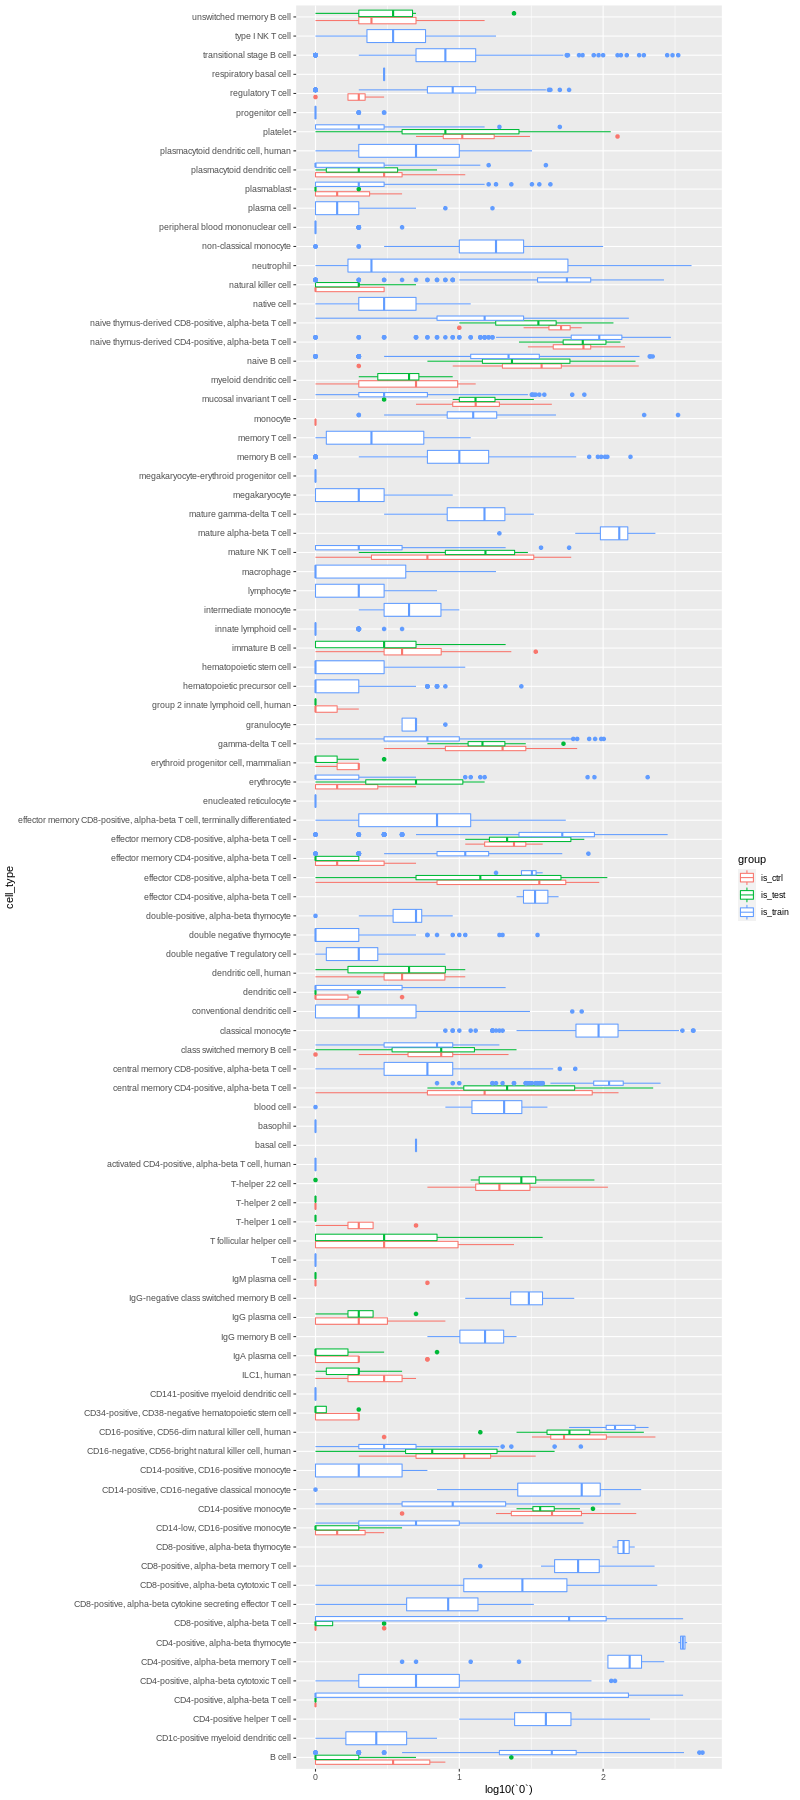

In [92]:
%%R -h 1800 -w 800
ct_size %>%
ggplot(aes(cell_type, log10(`0`))) +
geom_boxplot(aes(color=group)) +
coord_flip()

In [94]:
perturb_pop = ["naive B cell"]
adata.obs.loc[(adata.obs[population_obs].isin(perturb_pop)),
              'is_train'] = 0
adata.obs.loc[(adata.obs[population_obs].isin(
        perturb_pop)), 'is_ctrl'] = 0

In [112]:
# test that no cell is assigned to multiple splits
assert adata.obs[['is_train', 'is_test', 'is_ctrl']].sum(1).max() == 1

# test that perturbed population is in condition dataset only
assert adata[adata.obs['is_test'] == 1].obs[population_obs].isin(perturb_pop).sum() > 0
assert adata[adata.obs['is_train'] == 1].obs[population_obs].isin(perturb_pop).sum() == 0
assert adata[adata.obs['is_ctrl'] == 1].obs[population_obs].isin(perturb_pop).sum() == 0

In [120]:
adata_atlas = adata[adata.obs['is_train']==1].copy()
adata_ctrl = adata[adata.obs['is_ctrl']==1].copy()
adata_query = adata[adata.obs['is_test']==1].copy()

In [127]:
gdrive_dir = '/home/jovyan/mount/gdrive/query2reference/PBMC_CZIintegration_data/'
adata_atlas.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.atlas.h5ad')
adata_query.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.query.h5ad')
adata_ctrl.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.ctrl.h5ad')

With scVI/scArches
---

In [35]:
## Feature selection on reference only
n_hvgs = 5000
overwrite_models = False

if 'log1p' not in adata_ref.uns.keys():
    sc.pp.normalize_per_cell(adata_ref)
    sc.pp.log1p(adata_ref)

sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=n_hvgs,
    subset=True
)

hvgs = adata_ref.var_names.values

In [36]:
sim_id = f"queryBatch{'-'.join(query_batch)}_ctrlBatch{'-'.join(ctrl_batch)}_perturb_{population_obs}{clean_pop_name('-'.join(perturb_pop))}"
if not os.path.exists(outpath + h5ad_file.split('.h5ad')[0] + "_models"):
    print('bubi')
    os.mkdir(h5ad_file.split('.h5ad')[0] + "_models")

In [38]:
## Train reference model
if not os.path.exists(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_reference_{sim_id}/") or overwrite_models:
    vae_ref = q2r_uncertainty.train_models.train_scVI._train_model(adata_ref, hvgs, batch_col=batch_obs)
    vae_ref.save(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_reference_{sim_id}/", overwrite=True)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 26031 cells, 5000 vars, 14        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
## Map query datasets 
vae_ctrl_fit = q2r_uncertainty.train_models.train_scVI._fit_model(adata_ctrl, vae_ref, batch_col=batch_obs)
vae_ctrl_fit.save(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_ctrl_fit_{sim_id}/", overwrite=True)
vae_query_fit_ref = q2r_uncertainty.train_models.train_scVI._fit_model(adata_query, vae_ref, batch_col=batch_obs)
vae_query_fit_ref.save(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_query_fit_reference_{sim_id}/", overwrite=True)


With CellTypist
--

### Train celltypist reference model

In [123]:
adata_atlas.layers['counts'] = adata_atlas.X.copy()

In [124]:
sc.pp.normalize_total(adata_atlas, target_sum=10000)
sc.pp.log1p(adata_atlas)

In [125]:
new_model = celltypist.train(adata_atlas, labels = 'cell_type', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
⚠️ Warning: it may take a long time to train this dataset with 589174 cells and 11724 genes, try to downsample cells and/or restrict genes to a subset (e.g., hvgs)


KeyboardInterrupt: 

In [ ]:
new_model.write(data_dir + 'PBMC_merged.normal.subsample500cells.celltypist_model.pkl')

### Predict cell type labels

In [19]:
adata_query.layers['counts'] = adata_query.X.copy()
adata_ctrl.layers['counts'] = adata_ctrl.X.copy()

In [26]:
adata_query.var_names = adata_query.var['SYMBOL'].values.astype('str')
adata_ctrl.var_names = adata_ctrl.var['SYMBOL'].values.astype('str')

In [20]:
sc.pp.normalize_total(adata_query, target_sum=10000)
sc.pp.log1p(adata_query)

In [27]:
predictions_query = celltypist.annotate(adata_query, 
                                  model = data_dir + 'PBMC_merged.normal.subsample500cells.celltypist_model.pkl',
                        majority_voting = False)

🔬 Input data has 56122 cells and 29453 genes
🔗 Matching reference genes in the model
🧬 3058 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [29]:
sc.pp.normalize_total(adata_ctrl, target_sum=10000)
sc.pp.log1p(adata_ctrl)

In [30]:
predictions_ctrl = celltypist.annotate(adata_ctrl, 
                                  model = data_dir + 'PBMC_merged.normal.subsample500cells.celltypist_model.pkl',
                        majority_voting = False)

🔬 Input data has 30703 cells and 29453 genes
🔗 Matching reference genes in the model
🧬 3058 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
